lets now design RESNET15 MODEL2


In [2]:
import h5py
import numpy as np
from  sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os
from torch.utils.data import Dataset, DataLoader

In [3]:
#file path
photon_file = r"D:\ML4SCI_CMS\CommonTask1\photon_data\SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
electron_file = r"D:\ML4SCI_CMS\CommonTask1\electron_data\SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"

#load photon data
with h5py.File(photon_file, 'r') as f:
    X_photon = f['X'][:]  # Load images
    y_photon = f['y'][:]  # Load labels

#load electron data 
with h5py.File(electron_file, 'r') as f:
    X_electron = f['X'][:]
    y_electron = f['y'][:] 


# merge photon and electron data
X = np.concatenate((X_photon, X_electron), axis=0)
y = np.concatenate((y_photon, y_electron), axis=0)

# Split into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print dataset shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (398400, 32, 32, 2), y_train shape: (398400,)
X_test shape: (99600, 32, 32, 2), y_test shape: (99600,)


In [4]:
xtrain_mean = np.mean(X_train,axis=(0, 1, 2))
xtrain_std = np.std(X_train,axis=(0, 1, 2))

print("Mean:",xtrain_mean)
print("Standard Deviation:", xtrain_std) 

Mean: [ 0.0011495  -0.00023346]
Standard Deviation: [0.02360971 0.06675196]


In [5]:
#using transform to create tensor obj  and normalization  of data 
transform = transforms.Compose([
    # transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32).permute(2, 0, 1)),  #convert it to  channel height weight
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.0011495 , -0.00023346], std=[0.02360971 , 0.06675196])  
])

# Define ParticleDataset
class ParticleDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]  # Image shape: (32, 32, 2)
        label = self.y[idx]  # Class: 0 (proton) or 1 (electron)

        if self.transform:
            image = self.transform(image)

        return image, label

# Apply transformations
dataset = ParticleDataset(X_train, y_train, transform=transform)
datasett = ParticleDataset(X_test,y_test,transform=transform)
# dataloaders
Train_loader1 = DataLoader(dataset, batch_size=64, shuffle=True)
Test_loader1 = DataLoader(datasett, batch_size=64, shuffle=True)

print("dataloader creater with  normalization")

dataloader creater with  normalization


In [6]:
for images, labels in Train_loader1:
    print("\n=== Batch Verification ===")
    print("Batch shape:", images.shape)  # Should be (batch_size, 2, 32, 32)
    print("Labels:", labels)  # Verify correct label assignment
    print("\nSample Image Tensor (1st image):")
    print(images[0])
    print(" min/max:", images[0].min().item(), images[0].max().item())  # Check normalization range
    break  #one iteration only


=== Batch Verification ===
Batch shape: torch.Size([64, 2, 32, 32])
Labels: tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1.,
        0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 0., 1., 0.,
        0., 1., 1., 0., 1., 1., 1., 0., 1., 0.])

Sample Image Tensor (1st image):
tensor([[[-0.0487, -0.0487, -0.0487,  ..., -0.0487, -0.0487, -0.0487],
         [-0.0487, -0.0487, -0.0487,  ..., -0.0487, -0.0487, -0.0487],
         [-0.0487, -0.0487, -0.0487,  ..., -0.0487, -0.0487, -0.0487],
         ...,
         [-0.0487, -0.0487, -0.0487,  ..., -0.0487, -0.0487, -0.0487],
         [-0.0487, -0.0487, -0.0487,  ..., -0.0487, -0.0487, -0.0487],
         [-0.0487, -0.0487, -0.0487,  ..., -0.0487, -0.0487, -0.0487]],

        [[ 0.0035,  0.0035,  0.0035,  ...,  0.0035,  0.0035,  0.0035],
         [ 0.0035,  0.0035,  0.0035,  ...,  0.0035,  0.0035,  0.0035],
         [ 0.003

In [7]:
import torch
import torch.nn as nn

# Residual Block 1 (Two conv layers)
class m2Block1(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(m2Block1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return torch.relu(out)

# Residual Block 2 (Three conv layers)
class m2Block2(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(m2Block2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = torch.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        return torch.relu(out)

# ResNet-15 Architecture
class ResNet15M2(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet15M2, self).__init__()
        self.conv1 = nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.layer1 = self.make_layer1(64, 64, stride=1)   # m2Block2
        self.layer2 = self.make_layer1(64, 128, stride=2)  # m2Block2
        self.layer3 = self.make_layer2(128, 256, stride=2) # m2Block1 → m2Block1
        self.layer4 = self.make_layer1(256, 512, stride=1) # m2Block2
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def make_layer1(self, in_channels, out_channels, stride):
        return nn.Sequential(
            m2Block2(in_channels, out_channels, stride)
        )
    
    def make_layer2(self, in_channels, out_channels, stride):
        return nn.Sequential(
            m2Block1(in_channels, out_channels, stride),
            m2Block1(out_channels, out_channels, stride=1)
        )
    
    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

# Create model instance
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNet15M2(num_classes=2).to(device)

# Print model summary
print(model)


ResNet15M2(
  (conv1): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): m2Block2(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): m2Block2(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, ep

Epoch [1/50], Loss: 0.6000, Train Accuracy: 68.26%
Epoch [2/50], Loss: 0.5627, Train Accuracy: 71.83%
Epoch [3/50], Loss: 0.5544, Train Accuracy: 72.38%
Epoch [4/50], Loss: 0.5489, Train Accuracy: 72.76%
Epoch [5/50], Loss: 0.5446, Train Accuracy: 73.10%
Epoch [6/50], Loss: 0.5415, Train Accuracy: 73.28%
Epoch [7/50], Loss: 0.5389, Train Accuracy: 73.51%
Epoch [8/50], Loss: 0.5362, Train Accuracy: 73.61%
Epoch [9/50], Loss: 0.5340, Train Accuracy: 73.75%
Epoch [10/50], Loss: 0.5318, Train Accuracy: 73.96%
Epoch [11/50], Loss: 0.5299, Train Accuracy: 74.02%
Epoch [12/50], Loss: 0.5278, Train Accuracy: 74.23%
Epoch [13/50], Loss: 0.5256, Train Accuracy: 74.32%
Epoch [14/50], Loss: 0.5229, Train Accuracy: 74.53%
Epoch [15/50], Loss: 0.5206, Train Accuracy: 74.63%
Epoch [16/50], Loss: 0.5171, Train Accuracy: 74.90%
Epoch [17/50], Loss: 0.5140, Train Accuracy: 75.07%
Epoch [18/50], Loss: 0.5096, Train Accuracy: 75.34%
Epoch [19/50], Loss: 0.5050, Train Accuracy: 75.67%
Epoch [20/50], Loss: 

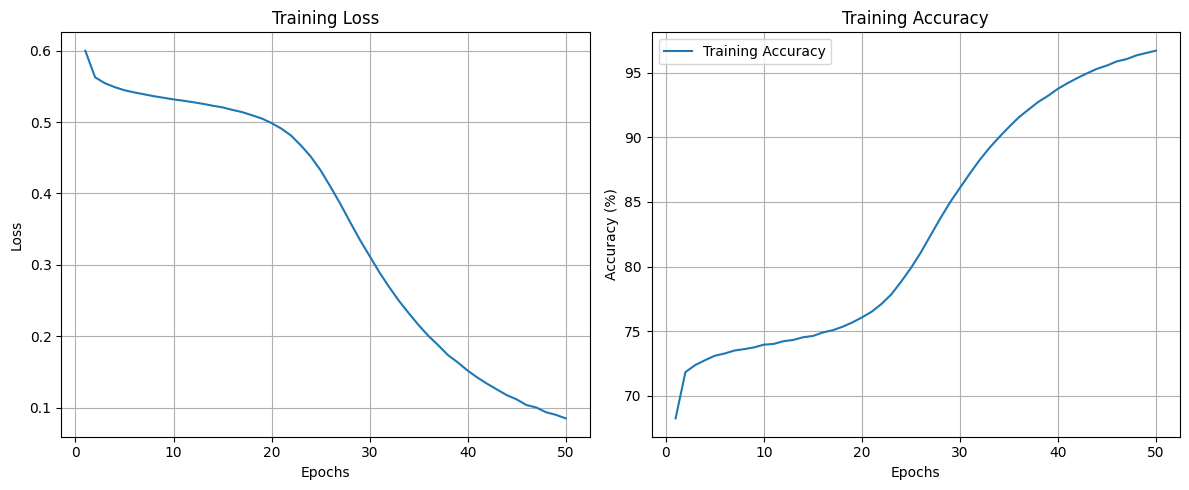

Test Accuracy: 67.85%


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

model2 = ResNet15M2(num_classes=1).to(device)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Sigmoid and binary cross-entropy
optimizer = optim.AdamW(model2.parameters(), lr=0.001, weight_decay=1e-4)

def plot(train_losses, train_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Plotting the loss curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid()

    # Plotting accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()


def train(model2, train_loader, criterion, optimizer, num_epochs=50):
    model2.train()

    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model2(images)  
            loss = criterion(outputs.squeeze(), labels.float()) 

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            predicted = (torch.sigmoid(outputs) > 0.5).float()  
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%")

    # Plotting the metrics after training is done
    plot(train_losses, train_accuracies)


def test(model2, test_loader):  
    model2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model2(images)  
            predicted = (torch.sigmoid(outputs) > 0.5).float() 
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy


train(model2, Train_loader1, criterion, optimizer, num_epochs=50)

test_accuracy = test(model2, Test_loader1)

# Save the model
torch.save(model2.state_dict(), 'resnet15_model2.pth')
